In [3]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import os
import re
import shutil
import sys
import ipywidgets
from scipy import stats
from os import listdir
from textwrap import wrap
import statistics
from sklearn.metrics import r2_score
#from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
pip install pytorch_lightning

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ModelAp29.ckpt to ModelAp29 (1).ckpt


In [ ]:
class block_1d(pl.LightningModule):
    def __init__(self,in_dim,out_dim,activation=nn.ReLU,dropout = 0.5):
#         self.learning_rate = lr
        super(block_1d, self).__init__()
        self.block = nn.Sequential(
            #nn.BatchNorm1d(in_dim),
#             nn.Dropout(dropout),
            nn.Linear(in_dim,out_dim, bias=True),
#             nn.Linear(in_dim,out_dim),
            activation(),
        )

    def forward(self, x):
        out = self.block(x)
        return out
###############################################################################
class res_block_1d(pl.LightningModule):
    def __init__(self, in_dim, out_dim, activation=nn.ReLU,dropout = 0.5):
        super(res_block_1d, self).__init__()
        self.activation = activation()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_dim),
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim, bias=True),
            activation(),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(dropout),
            nn.Linear(out_dim, out_dim, bias=True),
            activation(),
        )

    def forward(self, x):
#         out = self.activation(self.block(x) + x)
        out = self.block(x) + x
        return out
################################################################################  
class resnet(pl.LightningModule):
    def __init__(self, in_dim, out_dim, layers):
        #layers: list of layer_spec
        #layer_spec: list of [block_type, block dimenssion, block activation, dropout]
        super(resnet, self).__init__()
        self.loss = nn.MSELoss()
        self.num_layers = len(layers)+1
        for index in range(self.num_layers):
            if index == 0 :
                setattr(self, "layer_" + str(index), layers[index][0](in_dim, layers[index][1], layers[index][2],layers[index][3]))
            elif index == self.num_layers-1:
                setattr(self, "layer_" + str(index), nn.Linear(layers[index-1][1], out_dim))
            else:
                setattr(self, "layer_" + str(index), layers[index][0](layers[index-1][1], layers[index][1],layers[index][2],layers[index][3]))
    
    def forward(self, x):
        for index in range(self.num_layers):
            x = getattr(self, "layer_" + str(index))(x)
        return x
###################################################################################    
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                   batch_size=batch_size,
                                                   #sampler=train_sampler,
                                                   drop_last = False,
                                                   shuffle=True,
                                                   num_workers=1,
                                                   pin_memory = True)
        return train_loader

    def val_dataloader(self):
        validation_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                                        batch_size=batch_size,
                                                        #sampler=valid_sampler,
                                                        drop_last = False,
                                                        shuffle=True,
                                                        num_workers=1,
                                                        pin_memory = True)
        return validation_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                  batch_size=batch_size,
                                                  #sampler=test_sampler,
                                                  drop_last = False, 
                                                  shuffle=False,
                                                  num_workers=1,
                                                  pin_memory = False)
        return test_loader   
#################################################################################    
    def training_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('train_loss_step', loss)#,prog_bar=True)
        return {'loss': loss}

    def training_step_end(self, outputs):
        return outputs
    
    def training_epoch_end(self, outputs) -> None:
        self.log('train_loss_epoch',torch.stack([x['loss'] for x in outputs]).mean())
        
    ########################################################    
        
    def validation_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('val_loss_step', loss)#, prog_bar=True)
        return {'val_loss':loss}
    

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self,outputs)->None:
        self.log('val_loss_epoch',torch.stack([x['val_loss'] for x in outputs]).mean())
        
    ########################################################
  
    def test_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log("test_loss", loss)#, prog_bar=True)
        return {'test_loss':loss}

    def test_epoch_end(self,outputs)->None:
        torch.stack([x['test_loss'] for x in outputs]).mean()

    ########################################################

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr= 1e-3)
        return optimizer

In [ ]:
# Load saved model 
layers = [[block_1d,128,nn.ReLU,0]]
dim_output = 57
dim_input = 38
num_blocks = 8

for i in range(num_blocks):
    layers.append([res_block_1d,128,nn.ReLU,0.2])  
 
new_model = resnet.load_from_checkpoint("ModelAp29.ckpt", in_dim = dim_input, out_dim = dim_output, layers = layers )

In [5]:
cols_2030 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 18, 23, 26, 29, 32, 35]

In [6]:
list2030 = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 28, 29, 30, 31, 32, 33, 51, 54]

In [10]:
#maximum derivatives og outputs to inputs to find the correlations save to an array just for 2030
inputs_dict = {}
outputs_dict = {}
dim_input = 38
torch.manual_seed(0)
new_model.eval()
matrix_2030 = np.zeros([len(list2030), len(cols_2030)],dtype='float32')
rand_list = np.unique(np.round(np.random.uniform(-3, 3, 10000), 3))
z1 = torch.FloatTensor(np.sort(rand_list[1:1001]))

for j in range(len(cols_2030)):
    x_train_new = torch.zeros(1000,dim_input)
    x_train_new[:,cols_2030[j]] = z1
    inputs_dict [j] = x_train_new

    with torch.no_grad():
        y_new = new_model(x_train_new)
        outputs_dict[j] = y_new
    for i in range(len(list2030)):     
        diff = np.diff(y_new[:,list2030[i]])/np.diff(x_train_new[:,cols_2030[j]])
        max_abs = np.max(np.absolute(diff))
        max_idx = np.where(np.absolute(diff) == max_abs)        
        n = diff[max_idx]                   
        sign_max = np.sign(n)
        max_diff = sign_max*max_abs
        matrix_2030[i, j] = max_diff[0]

In [11]:
matrix_2030_norm = matrix_2030/(np.max(np.max(np.absolute(matrix_2030))))

In [12]:
matrix_2030_norm = np.around(matrix_2030_norm, 3)

In [18]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [13]:
dim_input = 38
dim_output = 57

# torch.manual_seed(0)
# new_model.eval()
# rand_list = np.random.uniform(-3, 3, 1000)
# z1 = torch.FloatTensor(rand_list)


num_col = len(cols_2030)
num_row = len(list2030)
# num_row = len(main_outputs)

min_y = torch.zeros(num_row)
max_y = torch.zeros(num_row)

for j in range(num_col):
    # x_train_new = torch.zeros(1000,dim_input)
    x_train_new = inputs_dict[j]
    # with torch.no_grad():
    y_new = outputs_dict[j]
        
    for i in range(num_row):
        if min_y[i] > torch.min( y_new[:,list2030[i]]):
            min_y[i] = torch.min( y_new[:,list2030[i]])
        if max_y[i] <  torch.max( y_new[:,list2030[i]]):    
            max_y[i] = torch.max( y_new[:,list2030[i]])

In [36]:
print(matrix_2030_norm[-3,3])

0.019


<Figure size 432x288 with 0 Axes>

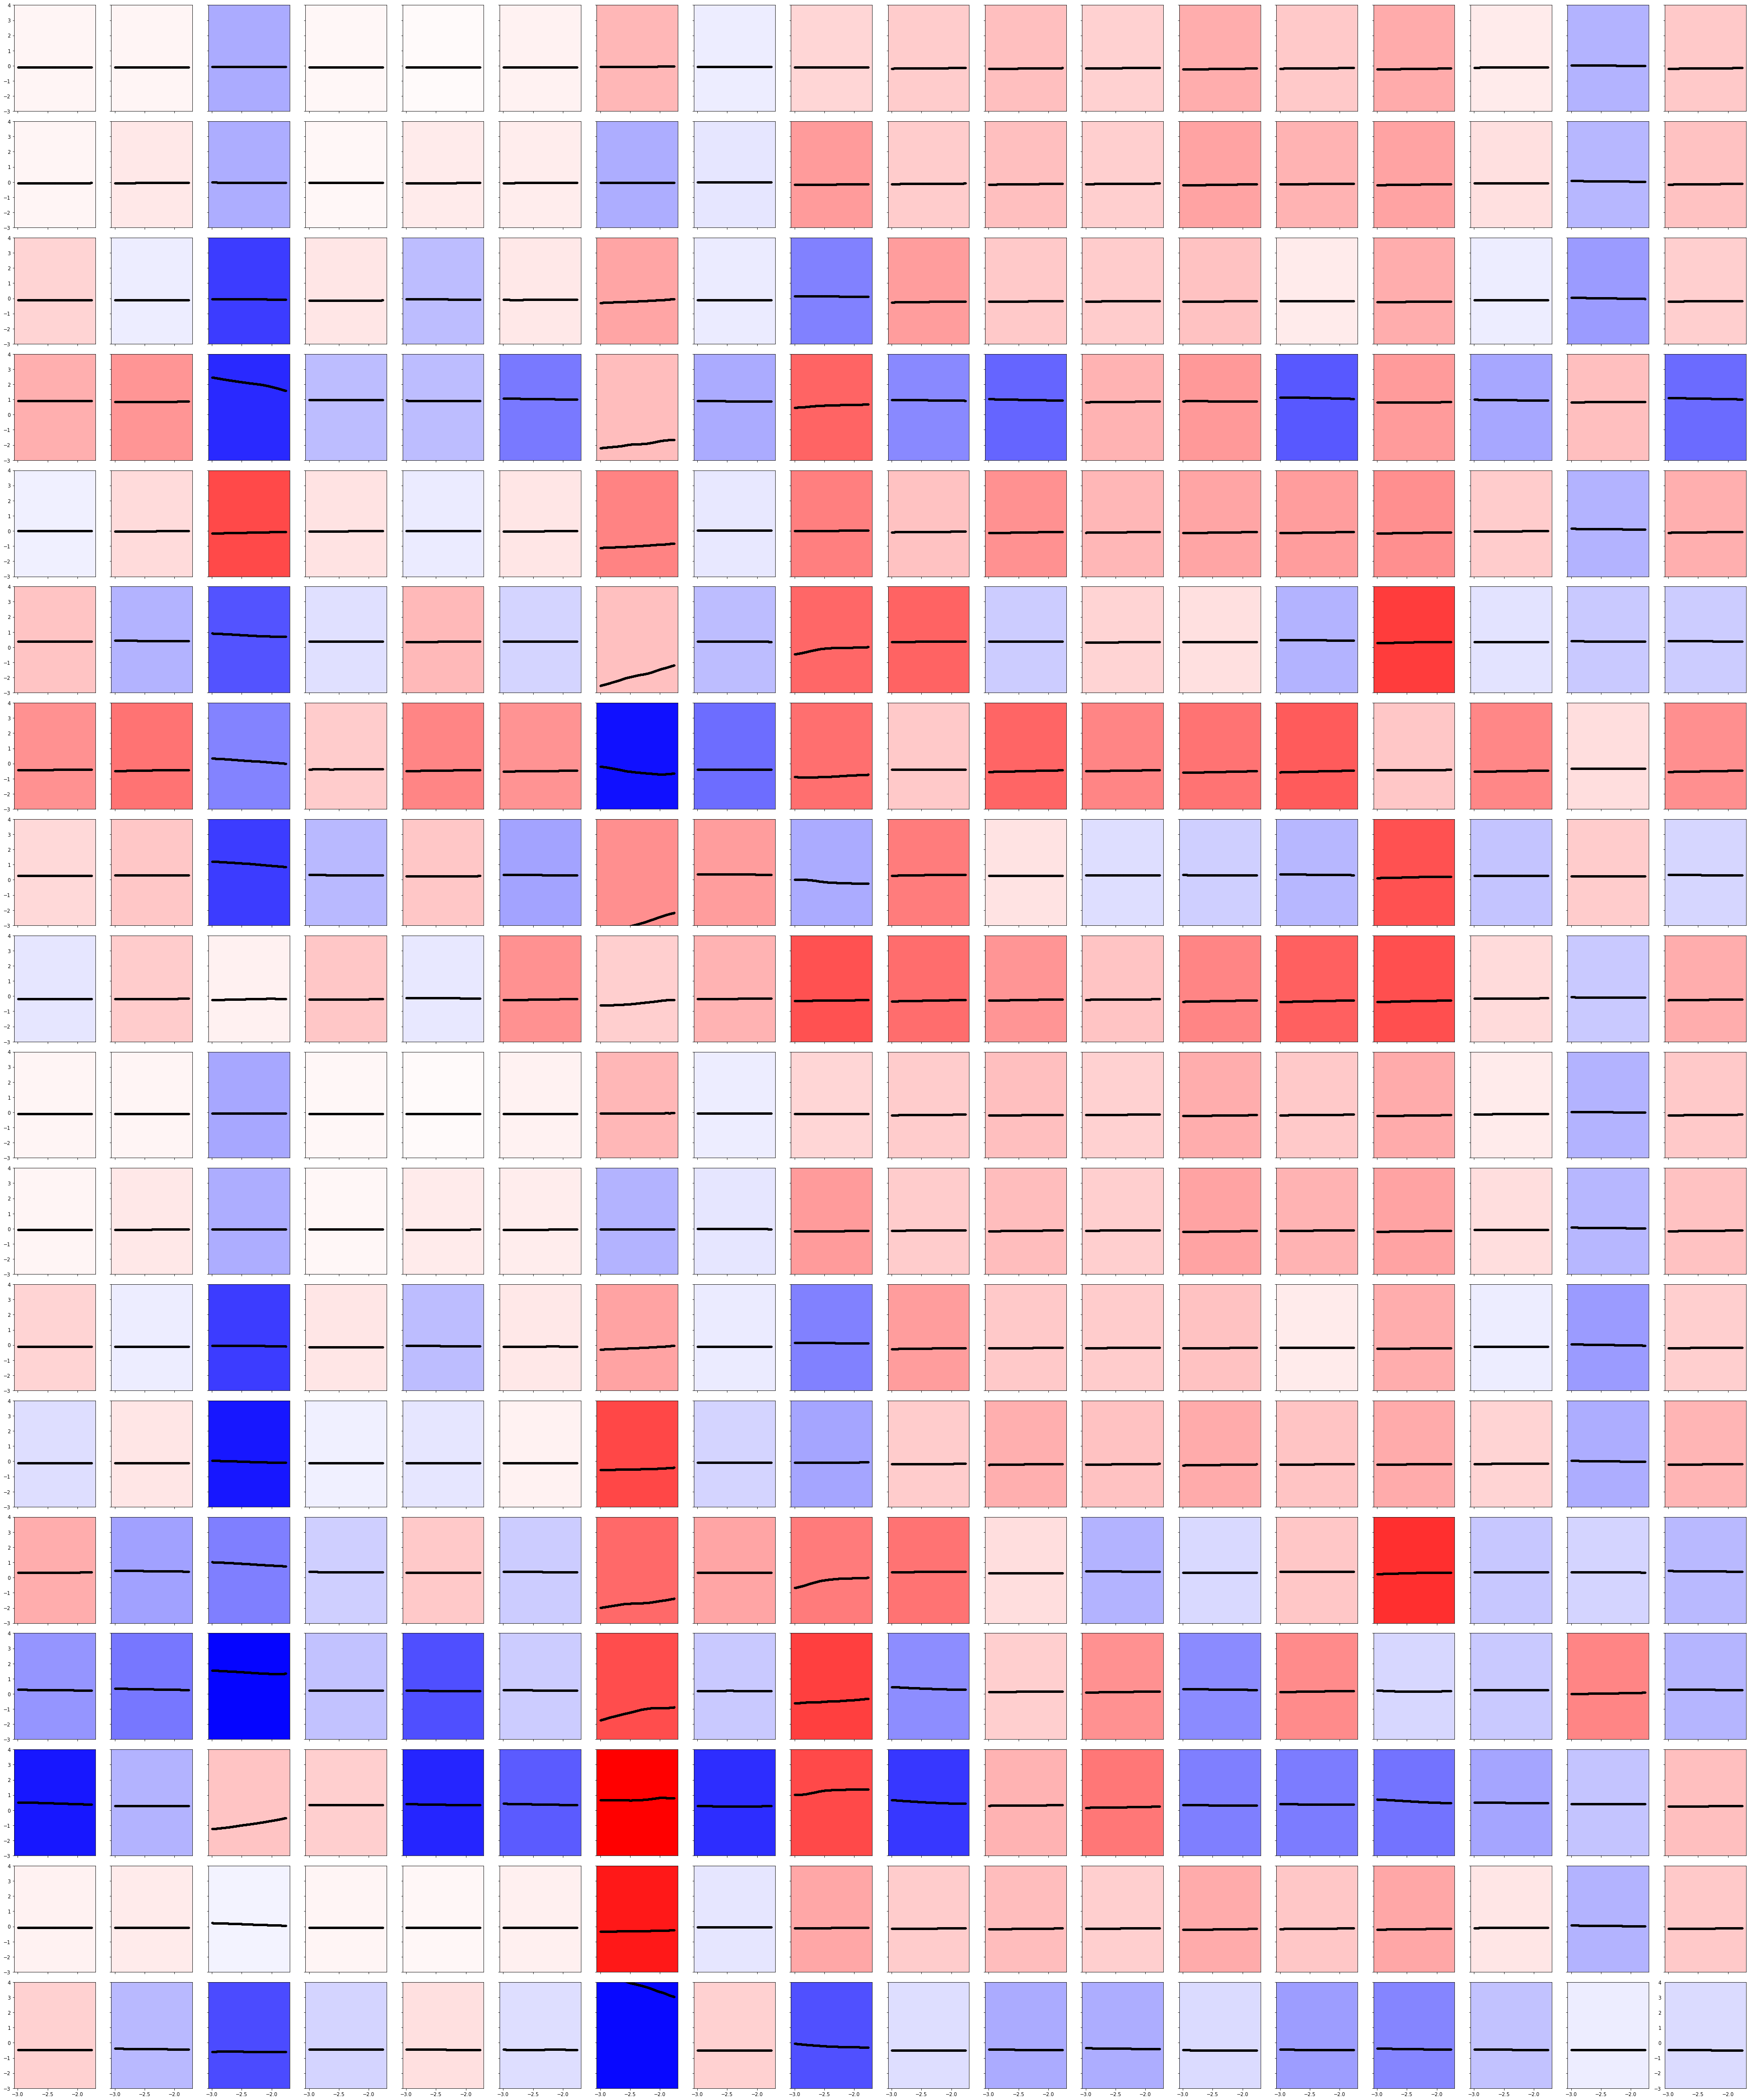

In [40]:
# Predictions with the model by randomly changing each inputs (1000 sample of each) and plot output vs each input
from matplotlib import gridspec
dim_input = 38
torch.manual_seed(0)
new_model.eval()
rand_list = np.unique(np.round(np.random.uniform(-3, 3, 10000), 3))
z1 = torch.FloatTensor(np.sort(rand_list[1:1001]))

main_outputs = list2030
num_col = len(cols_2030)
num_row = len(list2030)

f = plt.figure()   
f,axsi = plt.subplots(num_row, num_col, figsize=(50,60), sharex=True, sharey='row')

# gs = gridspec.GridSpec(num_row, num_col, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#          wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

for j in range(num_col):
    # x_train_new = torch.zeros(1000,dim_input)
    # x_train_new[:,cols_2030[j]] = z1
    # with torch.no_grad():
    #     y_new = new_model (x_train_new)
    x_train_new = inputs_dict[j]
    # with torch.no_grad():
    y_new = outputs_dict[j]
        
    for i in range(num_row):
#         if max_y[i] - min_y[i] < 0.05:
#             y_new[:, i] = 0
        axsi[i][j].scatter(x_train_new[:,cols_2030[j]], y_new[:,list2030[i]], s = 8, color= 'black')
        if matrix_2030_norm[i, j] > 0:
            axsi[i][j].patch.set_facecolor('red')
            axsi[i][j].patch.set_alpha(matrix_2030_norm[i, j]*10)
        elif matrix_2030_norm[i, j] < 0:
            axsi[i][j].patch.set_facecolor('blue')
            axsi[i][j].patch.set_alpha(np.absolute(matrix_2030_norm[i, j])*10)
        # axsi[i][j].set(xlabel= cols_2030[j], ylabel= list2030[i])
        axsi[i][j].set_ylim([-3, 4])
        # axsi[i][j].set_ylim([min_y[i], max_y[i]])

# for i in range (num_row):
#     for j in range(num_col):
#         axsi[i][j].set_xticks([])
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=True)

plt.tight_layout()